# Visual Question Answering on Tables &#x1F60E;
The goal for this notebook is to show how to apply Visual Question Answering on tables.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/JohnSnowLabs/spark-ocr-workshop/blob/webinar/webinars/VisualQuestionAnsweringOnTables.ipynb)



### Colab Setup

In [2]:
import json, os
from google.colab import files

if 'spark_jsl.json' not in os.listdir():
  license_keys = files.upload()
  os.rename(list(license_keys.keys())[0], 'spark_jsl.json')

with open('spark_jsl.json') as f:
    license_keys = json.load(f)

# Defining license key-value pairs as local variables
locals().update(license_keys)
os.environ.update(license_keys)

In [4]:
# Installing Spark OCR
!pip install --upgrade -q spark-ocr==$OCR_VERSION  --extra-index-url https://pypi.johnsnowlabs.com/$SPARK_OCR_SECRET

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
nlu 4.0.1rc4 requires spark-nlp<4.3.0,>=4.2.0, but you have spark-nlp 4.3.0 which is incompatible.
jsl-tmp 4.2.3rc15 requires pyspark==3.1.2, but you have pyspark 3.2.1 which is incompatible.
jsl-tmp 4.2.3rc15 requires spark-nlp==4.2.2, but you have spark-nlp 4.3.0 which is incompatible.
johnsnowlabs 4.2.5 requires pyspark==3.1.2, but you have pyspark 3.2.1 which is incompatible.
johnsnowlabs 4.2.5 requires spark-nlp==4.2.4, but you have spark-nlp 4.3.0 which is incompatible.
You should consider upgrading via the '/usr/bin/python3.7 -m pip install --upgrade pip' command.


### Initialize Spark session

In [ ]:
from sparkocr import start
import pkg_resources
from pyspark import SparkConf
from pyspark.ml import PipelineModel
import os

from sparkocr.transformers import *
from sparkocr.utils import display_images, display_table, display_tables
from sparkocr.enums import *


params = {"spark.driver.memory":"16G",
"spark.kryoserializer.buffer.max":"2000M",
"spark.driver.maxResultSize":"2000M"}

spark = start(license_keys['SPARK_OCR_SECRET'], extra_conf=params)
spark

## Load test documents
This time we will be using some publicly available documents from the Australian Stock Exchange. The Australian Securities and Investments Commission (ASIC), the equivalent to the SEC in the US requires public companies to fulfil some reports when people involved in the company y management acquires or sells some stock.</br>
Let's try to load some of these documents and run some interesting queries on them!</br>
In this example, we will use documents from a particular company as listed here,

https://www2.asx.com.au/markets/trade-our-cash-market/announcements.rff

02567277.pdf which is just a report of one of the board members buying stocks of the company.

In [ ]:
test_image_path = "./financial/*.pdf"
bin_df = spark.read.format("binaryFile").load(test_image_path)
bin_df.select("path").show(truncate=False)

## Define our pipeline
Let's unpack what we have here,
* PdfToImage will convert the input PDF files to images so the rest of the pipeline can process them.
* ImageTableDetector: we won't apply Visual Question Answering on the entire page, instead what we will be doing is detect the places in which the information is typically located, that is tables.
* ImageDrawRegions:  this one will help us visualize the tables we found on top of the image.

In [4]:
pdf_to_image = PdfToImage() \
        .setInputCol("content") \
        .setOutputCol("image") \
        .setImageType(ImageType.TYPE_3BYTE_BGR)

table_detector = ImageTableDetector \
        .pretrained("general_model_table_detection_v2", "en", "clinical/ocr") \
        .setInputCol("image") \
        .setOutputCol("regions") \
        .setScoreThreshold(0.9) \
        .setApplyCorrection(False)

draw_regions = ImageDrawRegions() \
        .setInputCol("image") \
        .setInputRegionsCol("regions") \
        .setOutputCol("image_with_regions") \
        .setRectColor(Color.red)

pipeline = PipelineModel(stages=[
    pdf_to_image,
    table_detector,
    draw_regions
])

general_model_table_detection_v2 download started this may take some time.
Approximate size to download 264.7 MB


### Apply the pipeline on the data
We will limit the input data to just 1 doc to speed up presentation

In [ ]:
result = pipeline.transform(bin_df.limit(1)).cache()

### Look into document pages


    Image #0:
    Origin: file:/home/jose/spark-ocr/workshop/webinars/financial/02567277.pdf
    Resolution: 0 dpi
    Width: 2480 px
    Height: 3508 px
    Mode: ImageType.TYPE_3BYTE_BGR
    Number of channels: 3


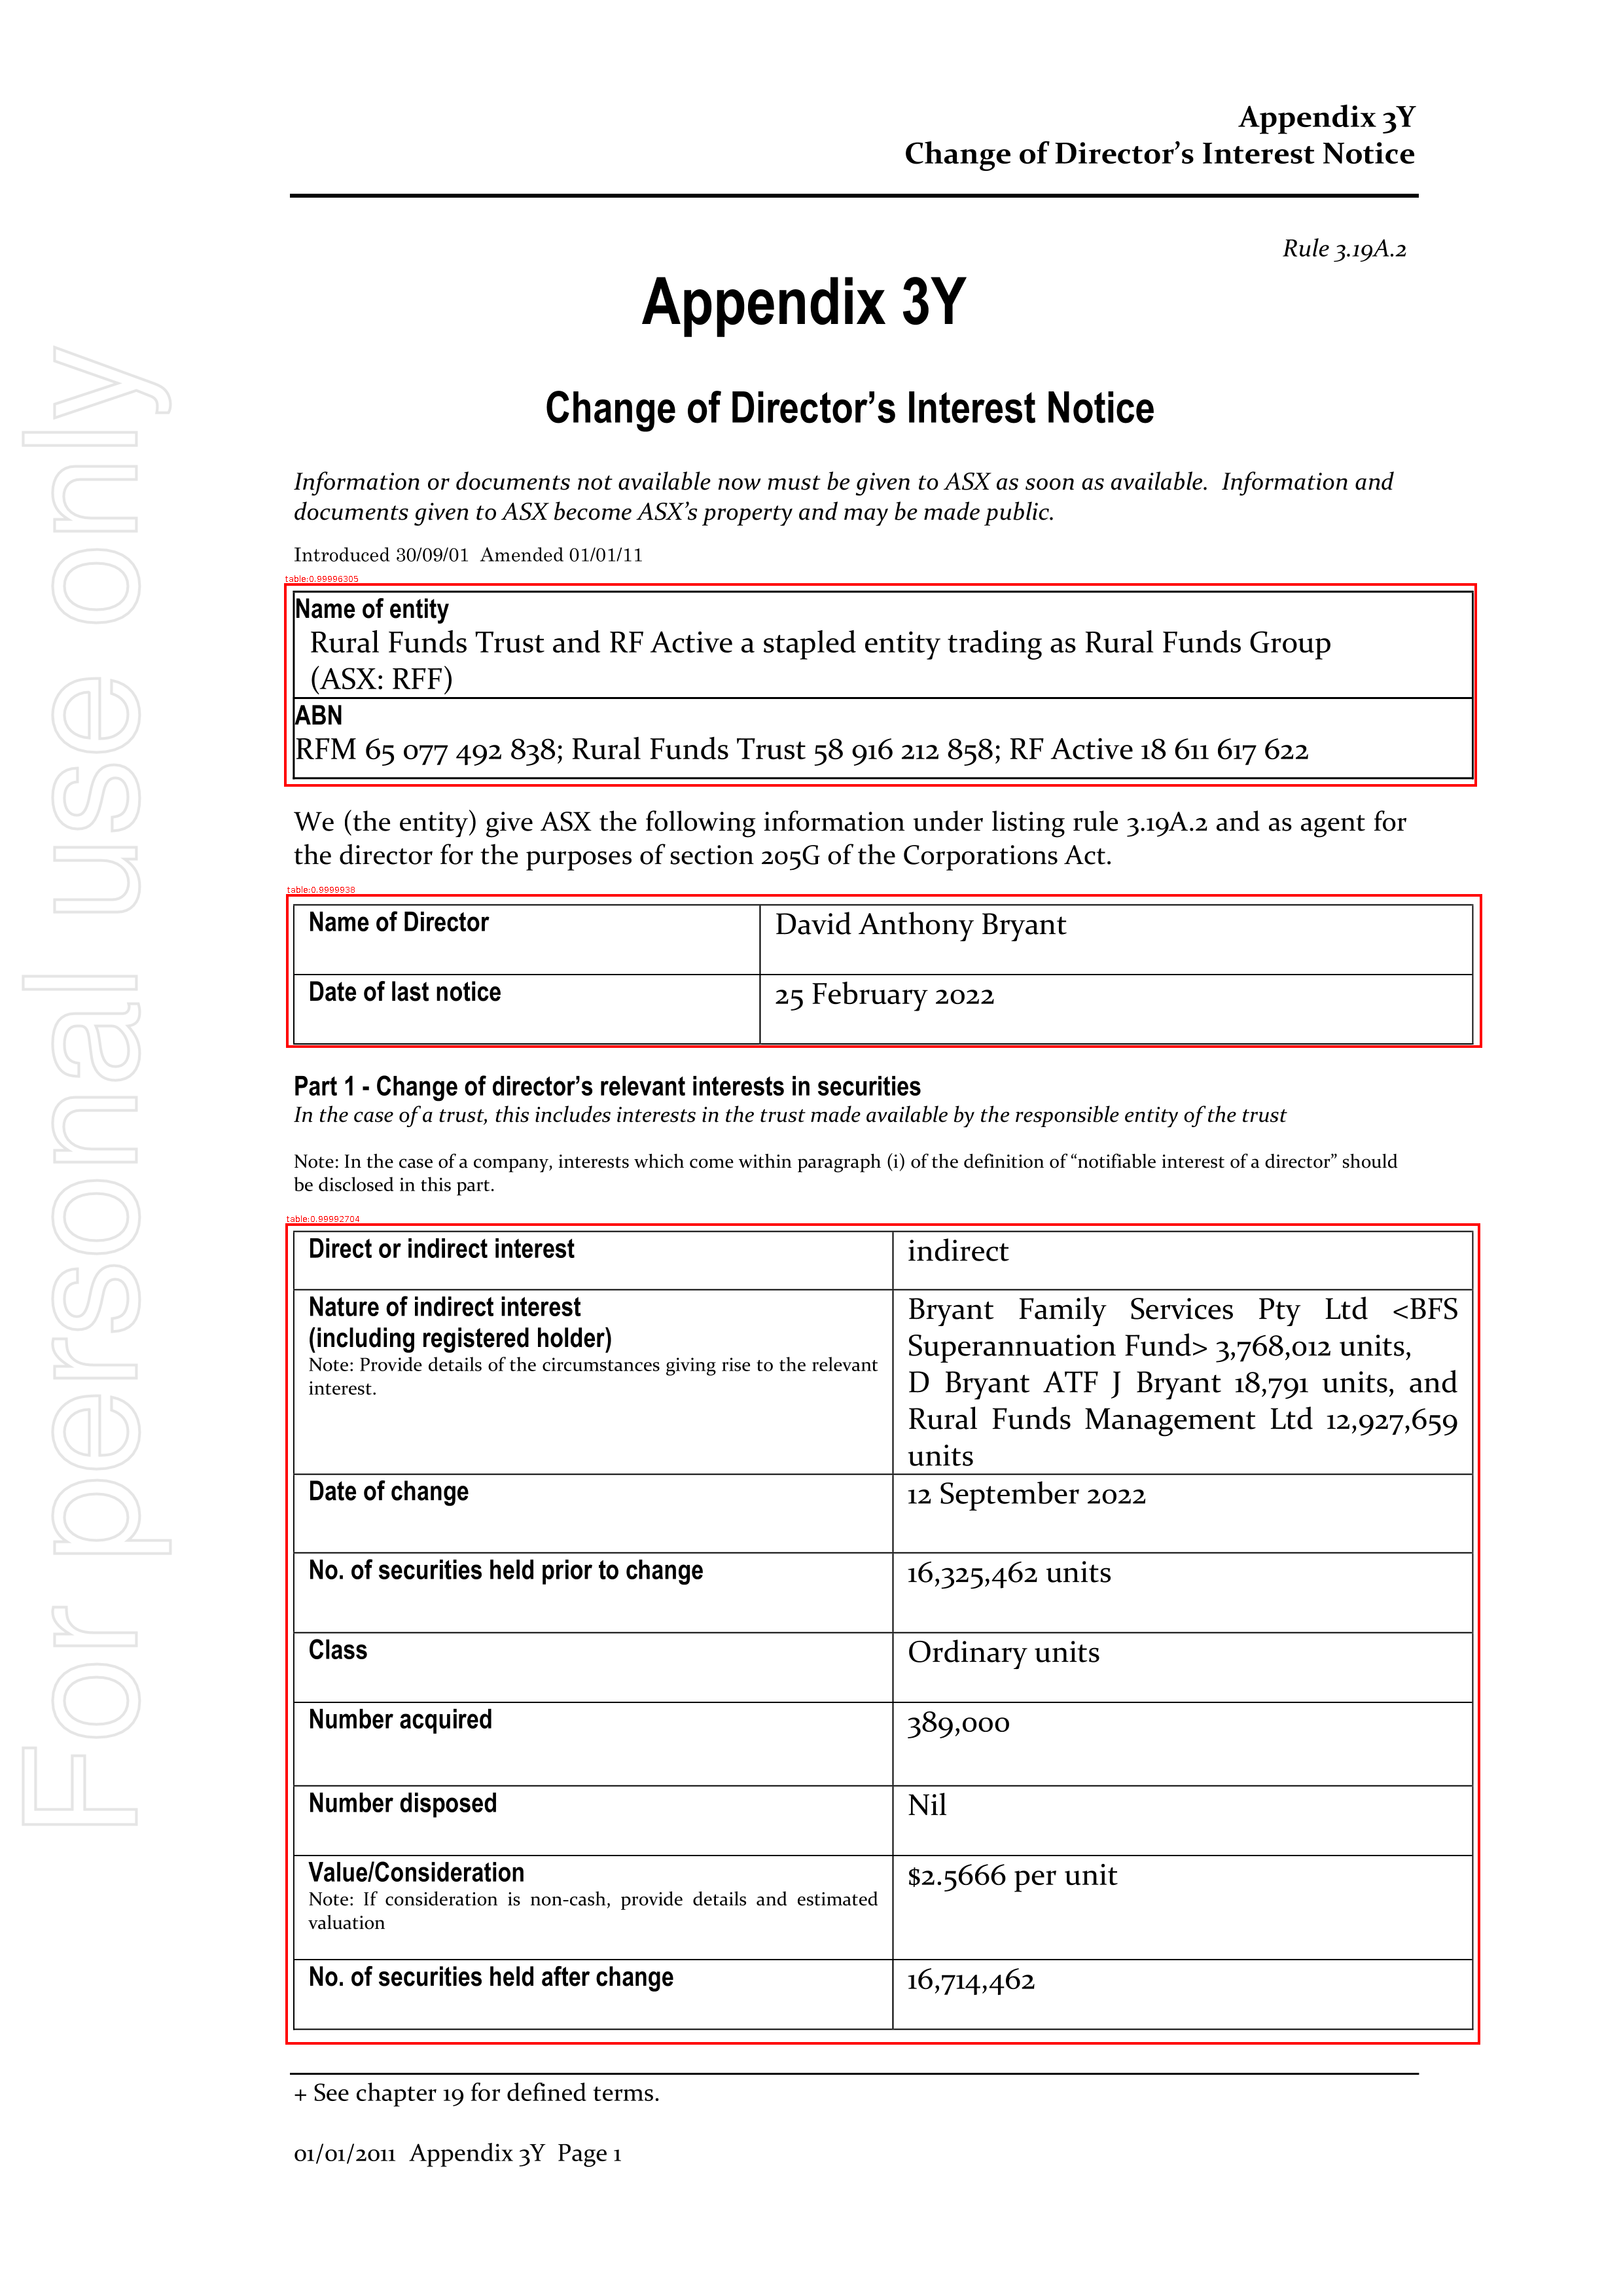


    Image #1:
    Origin: file:/home/jose/spark-ocr/workshop/webinars/financial/02567277.pdf
    Resolution: 0 dpi
    Width: 2480 px
    Height: 3508 px
    Mode: ImageType.TYPE_3BYTE_BGR
    Number of channels: 3


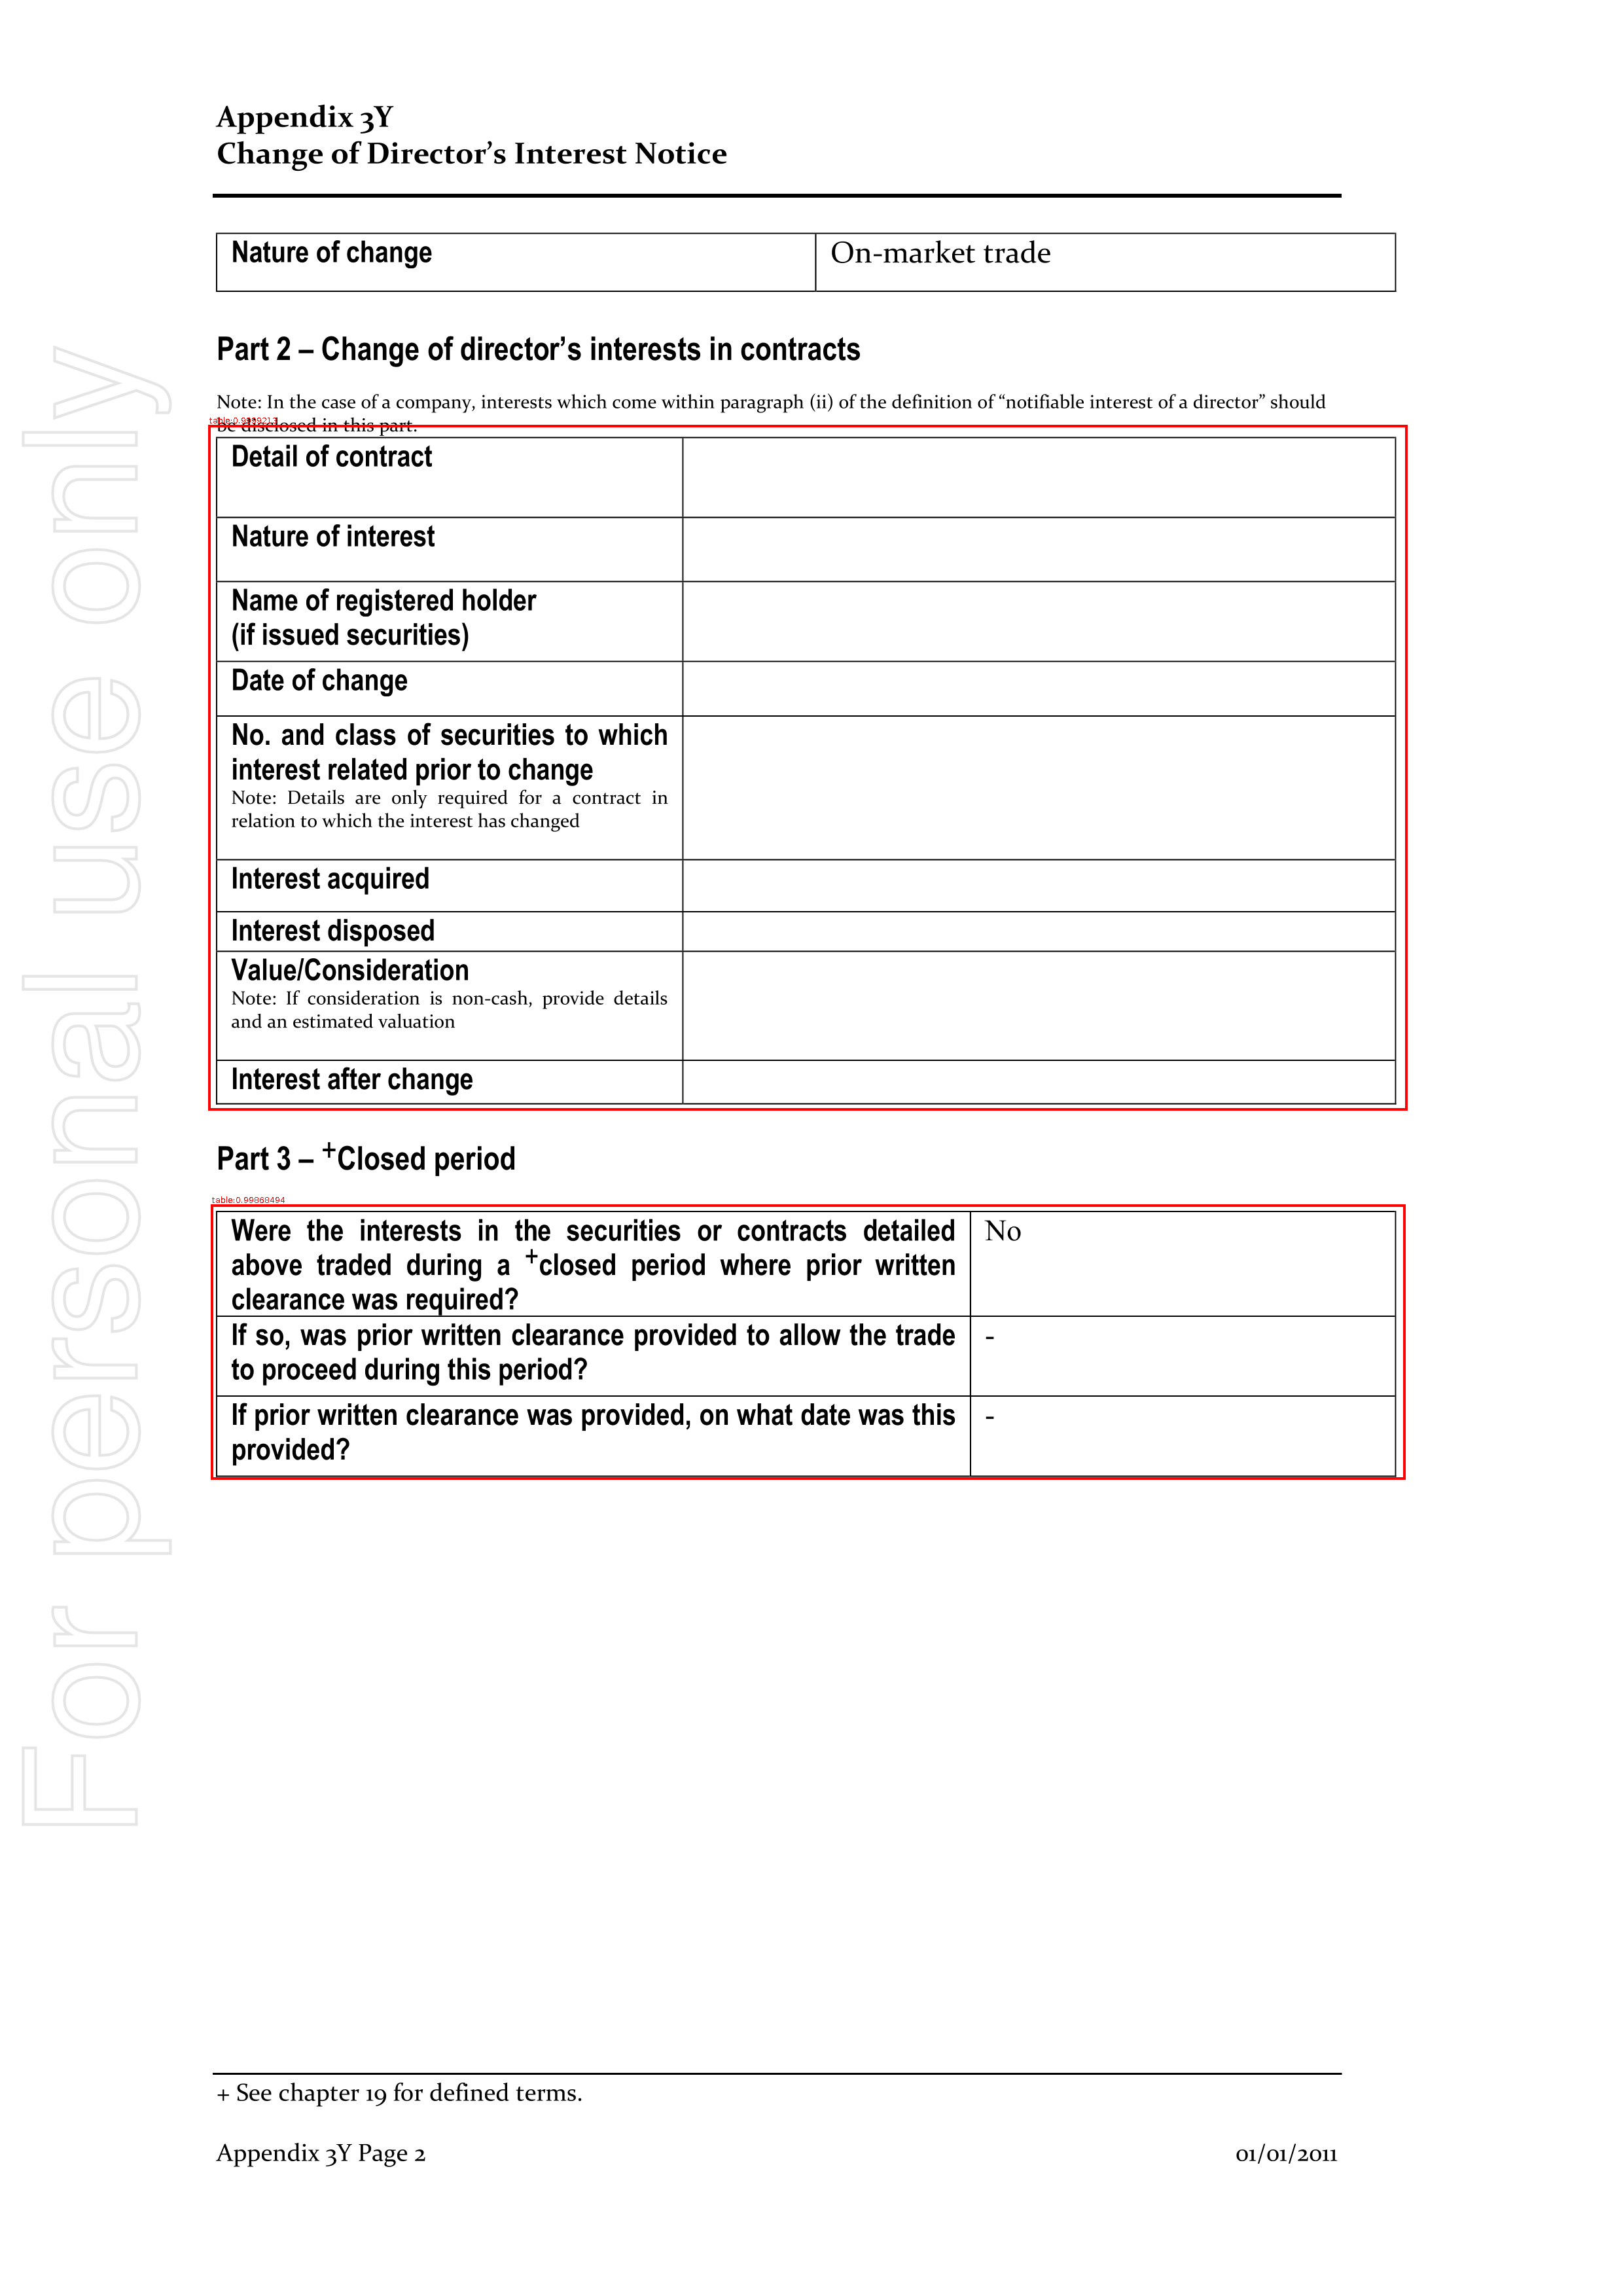

In [5]:
display_images(result.select("image_with_regions"), "image_with_regions")

### Question Answering Pipeline
Well, now we have identified the sections we care about, and we will focus on asking questions on these sections.
#### First things first; the questions themselves!

In [6]:
from pyspark.sql.functions import col

# this is an issue(or feature?) in table detector
tables = result.filter(col('regions').isNotNull())
questions = ["What is the number of acquired units?",
             "What is the number of disposed units?",
             "What is the value per unit?"]

#### The pipeline

In [7]:
# Extract table regions to separate images
splitter = ImageSplitRegions() \
        .setInputCol("image") \
        .setInputRegionsCol("regions") \
        .setOutputCol("table_images") \
        .setExplodeCols(["regions"])

visual_question_answering = VisualQuestionAnswering()\
    .pretrained("docvqa_donut_base_opt", "en", "clinical/ocr")\
    .setQuestions(questions)\
    .setInputCol(['table_images']) \
    .setOutputCol("answers")

### Let's take a look at the tables
These are some numbers describing the number of tables and their sizes. You can skip if not interested.

In [8]:
exploded = splitter.transform(tables)
exploded.select("table_images.height", "table_images.width").show()
exploded.count()

+------+-----+
|height|width|
+------+-----+
|   231| 1824|
|   307| 1819|
|  1251| 1822|
|  1044| 1829|
|   417| 1822|
+------+-----+



5

### Run the pipeline
At this point we have found 5 tables, we have separated the regions in the image where they are located, and now we are ready to see the answers!

In [10]:
%%time
visual_question_answering.transform(exploded.repartition(6)).select("path", "answers").show(truncate=False)

+----------------------------------------------------------------------------------------------------------------+
|col                                                                                                             |
+----------------------------------------------------------------------------------------------------------------+
| What is the number of acquired units? ->  25 february 2022                                                     |
| What is the number of disposed units? ->  25 february 2022                                                     |
| What is the value per unit? ->  2022                                                                           |
| What is the number of acquired units? ->  858                                                                  |
| What is the number of disposed units? ->  622                                                                  |
| What is the value per unit? ->  858                                           

There are some false positives, there are some options to clean those by using regular expressions or even the confidence score returned by the model. We leave that as a homework!